In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 47.7 MB/s 
     |████████████████████████████████| 16.7 MB 49.9 MB/s 


### 1. 컨투어 찾기

In [ ]:
import os
import cv2
from shapely.geometry import Polygon
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

os.chdir('/content/drive/Shareddrives/msmg/level2/inference_output/') # 폴더 경로
img = cv2.imread('BLD00080_PS3_K3A_NIA0276.png') # 파일명

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # 흑백사진으로 변환
# ret, binary = cv2.threshold(gray, 240, 255, 0) # 정확도를 위한 부분

contours, h = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
image = cv2.drawContours(img, contours, -1, (0,255,0), 1)

(-0.5, 1023.5, 1023.5, -0.5)

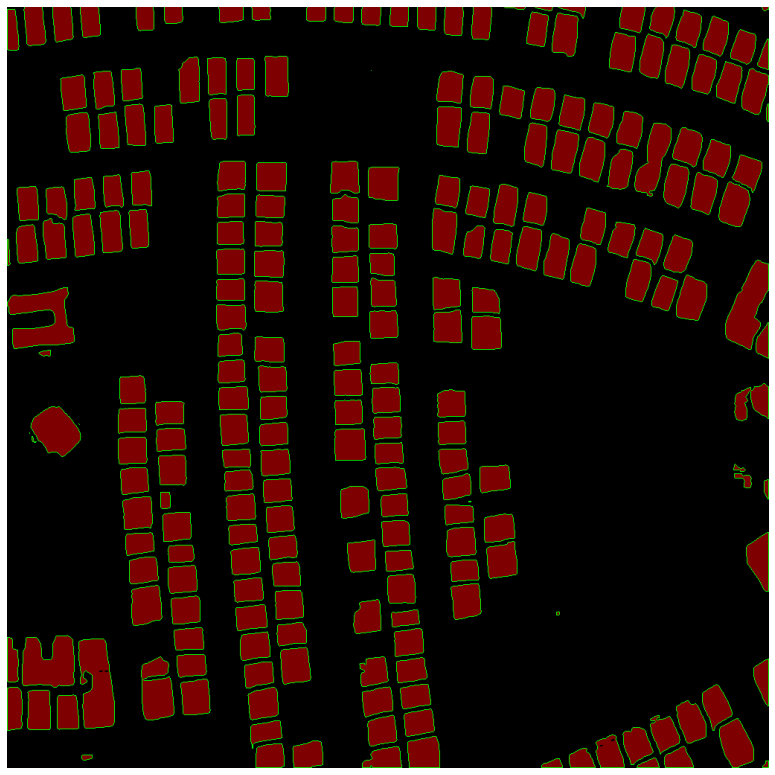

In [ ]:
# image 시각화

plt.figure(figsize=(14, 14))
plt.imshow(image)
plt.axis('off')

### 2. 폴리곤 변환

In [ ]:
poly_objs = []
for i in range(len(contours)):
    if (i > 0) and (len(contours[i]))>2:
        poly_objs.append(Polygon(np.squeeze(contours[i])))

polygons = poly_objs
polygons = gpd.GeoDataFrame(polygons, columns = ['geometry'])
polygons.to_file('/content/OBJ00352_PS3_K3_NIA0083.shp')

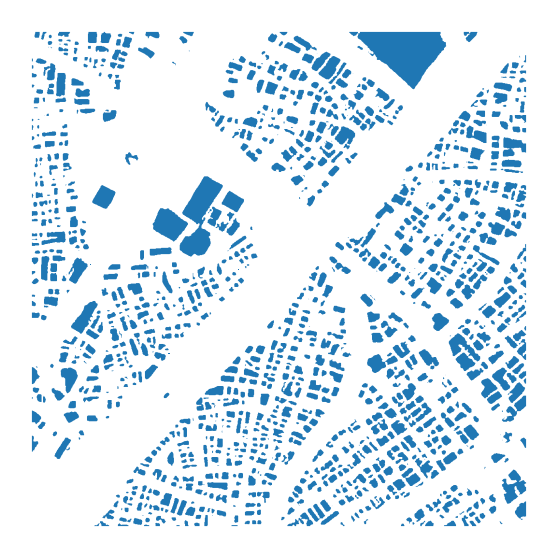

In [ ]:
# shp 파일 시각화

plt.rcParams["figure.figsize"] = (10, 10)

test_file = "/content/OBJ00352_PS3_K3_NIA0083.shp"
test = gpd.read_file(test_file)

ax = test.plot()
# ax = test.convex_hull.plot(color='purple', edgecolor="w")
# ax = test.envelope.plot(color='purple', edgecolor="w")

ax.invert_yaxis()
ax.set_axis_off()
plt.show()

### 3. RDP 적용
- Reference : https://github.com/yoojchul/rdp-for-polygon

In [ ]:
!pip install rdp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4588 sha256=919a59c55047530299454c168927f3b441f6823abec611bc84ab41594a859e72
  Stored in directory: /root/.cache/pip/wheels/ee/30/35/b52f1e297bfd39e8a51f203dc46dc50cf411a6cc151296b13f
Successfully built rdp


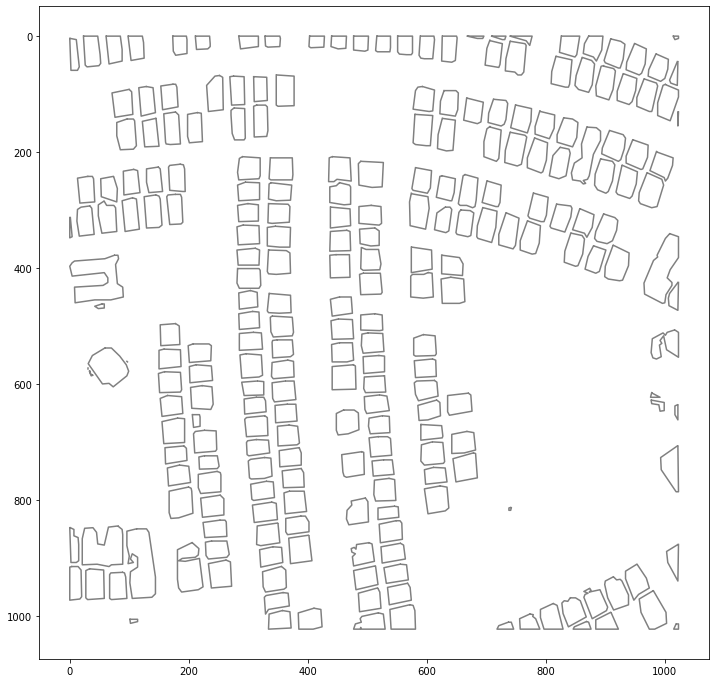

In [ ]:
# import json
import matplotlib.pyplot as plt
import numpy as np
from rdp import rdp

#html = urlopen("https://raw.githubusercontent.com/southkorea/seoul-maps/master/kostat/2013/json/seoul_municipalities_geo.json")
#jdata = html.read().decode('utf-8')
#geoJSON = json.loads(jdata)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.invert_yaxis()

polygons = []
new_polygons = []
pts=[]    # decrease resolution to four decimal places
for feature in range(len(contours)):
    pts = []
    prev_x = 0
    prev_y = 0
    for p in range(len(contours[feature])):
        x = round(contours[feature][p][0][0], 4)
        y = round(contours[feature][p][0][1], 4)
        if x == prev_x and y == prev_y:
            continue
        pts.append([x, y, 0])
        prev_x = x
        prev_y = y
    polygons.append(pts)

# accumulate neighbor in three decimal plances 
cum = {} 
for pl in polygons:
    visited = {}
    for p in pl:
        dot = (round(p[0], 3), round(p[1], 3))
        if dot in visited:
            visited[dot] += 1
        else:
            visited[dot] = 1
        if dot in cum:
            if visited[dot] == 1:   #  to prevent p in same pl
                cum[dot] += 1
        else:
            cum[dot] = 1
# assign neighbor counter to 3rd 
for pl in polygons:
    for p in pl:
        p[2] = cum[(round(p[0], 3), round(p[1], 3))]

# find _joints_ where lines meet
joints = []
for pl in polygons:
    multi = pl[0][2]
    prev =[p[0], p[1]]
    for p in pl[1:]:
        if multi < p[2]: # branch
            if not [p[0], p[1]] in joints:
                joints.append([p[0], p[1]])
        elif multi > p[2]:  # combine
            if not prev in joints:
                joints.append(prev)
        prev = [p[0], p[1]]
        multi = p[2]
x = []
y = []
for p in joints:
    x.append(round(p[0], 3))
    y.append(round(p[1], 3))
#ax.plot(x, y, 'o', color='red')

# 
for pl in polygons:
    multi = pl[0][2]
    pts = []
    if [pl[0][0], pl[0][1]] in joints: # to merge to joints
        pts.append([round(pl[0][0], 3), round(pl[0][1], 3)])
        prev = [round(pl[0][0], 3), round(pl[0][1], 3)]
    else:
        pts.append([pl[0][0], pl[0][1]])
        prev = [pl[0][0], pl[0][1]]
    for p in pl[1:]:  # from 2nd 
        if multi != p[2]:
            if multi < p[2]:  # 1-1-2
                min_dist =  100.0
                min_idx = 0
                for idx, val in enumerate(joints):   # find nearest joints
                    dist =  abs(val[0] - prev[0]) + abs(val[1] - prev[1])
                    if min_dist > dist:
                        min_idx = idx
                        min_dist = dist
                pts.append([round(joints[min_idx][0], 3),  round(joints[min_idx][1], 3)])
            rdp_pts = rdp(pts, epsilon=2.0)
            x = [i for i, j in rdp_pts]
            y = [j for i, j in rdp_pts]
            ax.plot(x, y, color='gray')
            pts = []
            if multi > p[2]:  # 2-2-1
                pts.append(prev)
        if [p[0], p[1]] in joints: # to merge to joinsts
            pts.append([round(p[0], 3), round(p[1], 3)])
            prev = [round(p[0], 3), round(p[1], 3)]
        else:
            pts.append([p[0], p[1]])
            prev = [p[0], p[1]]
        multi = p[2]
        
    rdp_pts = rdp(pts, epsilon=2.0)
    new_polygons.append(rdp_pts)
    x = [i for i, j in rdp_pts]
    y = [j for i, j in rdp_pts]
    ax.plot(x, y, color='gray')

### 4. RDP 적용 결과 폴리곤 변환

In [ ]:
poly_objs = []
for i in range(len(new_polygons)):
    if (i > 0) and (len(new_polygons[i]))>2:
        poly_objs.append(Polygon(np.squeeze(new_polygons[i])))

polygons = poly_objs
polygons = gpd.GeoDataFrame(polygons, columns = ['geometry'])

# polygons.to_file('/content/polygons.shp')

In [ ]:
polygons

,geometry
0,"POLYGON ((737.000 1011.000, 721.000 1017.000, ..."
1,"POLYGON ((868.000 1010.000, 848.000 1019.000, ..."
2,"POLYGON ((101.000 1006.000, 102.000 1013.000, ..."
3,"POLYGON ((773.000 997.000, 756.000 1005.000, 7..."
4,"POLYGON ((518.000 995.000, 491.000 1001.000, 4..."
...,...
231,"POLYGON ((211.000 0.000, 213.000 23.000, 232.0..."
232,"POLYGON ((173.000 0.000, 174.000 26.000, 178.0..."
233,"POLYGON ((98.000 0.000, 103.000 42.000, 125.00..."
234,"POLYGON ((61.000 0.000, 66.000 48.000, 88.000 ..."


### 5. .shp 파일에 .tif 파일의 geometry mapping

In [ ]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 6.9 MB/s 


In [ ]:
import rasterio
dataset = rasterio.open('/content/drive/MyDrive/SharedData/sia-satellite-data/Validation/vaildate_buildings_data/BLD00080_PS4_K3A_NIA0276.tif')
dataset.bounds

BoundingBox(left=337256.80134696, bottom=3321025.2769356696, right=337820.00134696, top=3321588.47693567)

In [ ]:
dataset.crs

CRS.from_epsg(32636)

### 6. pixel coordinate -> real long, lat

In [ ]:
print(polygons.geometry[0])

POLYGON ((737 1011, 721 1017, 718 1023, 746 1023, 742 1011, 738 1011, 737 1011))


In [ ]:
poly_coords = list(polygons.geometry[0].exterior.coords)
poly_coords[0]

(737.0, 1011.0)

In [ ]:
def pixel2coord(px, py):
    mx = dataset.bounds[0] + abs(dataset.bounds[0]-dataset.bounds[2]) * (px / 1024)
    my = dataset.bounds[1] + abs(dataset.bounds[1]-dataset.bounds[3]) * (abs(1024 - py) / 1024)

    return mx, my

In [ ]:
real_coords = tuple(pixel2coord(poly_coords[0][0], poly_coords[0][1]))

In [ ]:
real_coords

(337662.15134696005, 3321032.4269356695)

In [ ]:
real_polygons = []

for i in range(len(polygons.geometry)):
    real_coords = []
    poly_coords = list(polygons.geometry[i].exterior.coords)
    
    poly = Polygon(pixel2coord(poly_coords[j][0], poly_coords[j][1]) for j in range(len(poly_coords)))
    real_polygons.append(poly)

In [ ]:
data = {
    'geometry': real_polygons
    }

new_polygons = gpd.GeoDataFrame(data, crs="EPSG:32636")
new_polygons

,geometry
0,"POLYGON ((337662.151 3321032.427, 337653.351 3..."
1,"POLYGON ((337734.201 3321032.977, 337723.201 3..."
2,"POLYGON ((337312.351 3321035.177, 337312.901 3..."
3,"POLYGON ((337681.951 3321040.127, 337672.601 3..."
4,"POLYGON ((337541.701 3321041.227, 337526.851 3..."
...,...
231,"POLYGON ((337372.851 3321588.477, 337373.951 3..."
232,"POLYGON ((337351.951 3321588.477, 337352.501 3..."
233,"POLYGON ((337310.701 3321588.477, 337313.451 3..."
234,"POLYGON ((337290.351 3321588.477, 337293.101 3..."


In [ ]:
new_polygons.to_file('/content/drive/Shareddrives/msmg/level3/BLD00080_PS3_K3A_NIA0276.shp')